____

<div dir=ltr align=center>
<font color=0F5298 size=7>
    Massive Data Analysis <br>
<font color=FFFFFF size=5>
    Electrical Engineering Department <br>
    Fall 2024 <br>
    Arman Yazdani 400102255 <br>
<font color=696080 size=5>
    Homework 3 - Spark Exercise <br>
<font color=696880 size=4>
    Hossein Sharifi
    
____

# Spark initialization

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession as ss
spark = ss.builder.appName("MDA2024-HW3").master("local[*]").config("spark.executor.memory", "2g")\
    .config("spark.driver.memory", "2g").config("spark.hadoop.native.lib", "false").getOrCreate()
sc=spark.sparkContext
sc

<SparkContext master=local[*] appName=MDA2024-HW3>

# Dimentionality reduction & Clustering

## Dimentionality reduction

### Preprocessing

**Feature Engineering**:
   - **Quantitative Features**:
     - Identified features: $\text{Elevation}$, $\text{Slope}$, $\text{Aspect}$, etc.
     - Combined into a single vector, $\text{features\_raw}$, using a `VectorAssembler`.
     - Standardized using $z$-score normalization:
       $$z = \frac{x - \mu}{\sigma}$$
       where $\mu$ is the mean, and $\sigma$ is the standard deviation.
   - **Binary Features**:
     - Aggregated `Wilderness Area` and `Soil Type` columns into a single vector, $\text{binary\_features}$.
   - **Final Features**:
     - Combined scaled quantitative features and binary features into a unified vector, $\text{final\_features}$.

**Output**:
   - The DataFrame contained a column, $\text{final\_features}$, with all features compressed into a single vector.


In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StandardScaler, VectorAssembler

# Load the dataset
data_path = "Forest_covtype.csv"
df = spark.read.csv(data_path, header=False, inferSchema=True)

# Sample 50% of the data
df = df.sample(fraction=0.5, seed=42)  # Adjust 'seed' for reproducibility
sampled_indices = df.select("_c0").rdd.flatMap(lambda x: x).collect() #for saving down the road

# Remove the first column (row number), which is index 0 in the DataFrame
df = df.drop('_c0')

# Remove rows with any null values
df = df.dropna()

# Rename columns
df = df.withColumnRenamed("_c1", "Elevation") \
       .withColumnRenamed("_c2", "Aspect") \
       .withColumnRenamed("_c3", "Slope") \
       .withColumnRenamed("_c4", "Horizontal_Distance_To_Hydrology") \
       .withColumnRenamed("_c5", "Vertical_Distance_To_Hydrology") \
       .withColumnRenamed("_c6", "Horizontal_Distance_To_Roadways") \
       .withColumnRenamed("_c7", "Hillshade_9am") \
       .withColumnRenamed("_c8", "Hillshade_Noon") \
       .withColumnRenamed("_c9", "Hillshade_3pm") \
       .withColumnRenamed("_c10", "Horizontal_Distance_To_Fire_Points")

# Standardize quantitative features
quantitative_columns = [
    "Elevation", "Aspect", "Slope", 
    "Horizontal_Distance_To_Hydrology", 
    "Vertical_Distance_To_Hydrology", 
    "Horizontal_Distance_To_Roadways", 
    "Hillshade_9am", "Hillshade_Noon", 
    "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"
]
assembler = VectorAssembler(inputCols=quantitative_columns, outputCol="features_raw")
df = assembler.transform(df)

scaler = StandardScaler(inputCol="features_raw", outputCol="features_scaled", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Add binary Wilderness Area and Soil Type columns as features
wilderness_columns = [f"_c{i}" for i in range(11, 15)]
soil_columns = [f"_c{i}" for i in range(15, 55)]

assembler_binary = VectorAssembler(inputCols=wilderness_columns + soil_columns, outputCol="binary_features")
df = assembler_binary.transform(df)

# Combine scaled quantitative and binary features
final_assembler = VectorAssembler(inputCols=["features_scaled", "binary_features"], outputCol="final_features")
df = final_assembler.transform(df)

# Show the first 5 rows of the cleaned DataFrame
df.select("final_features").show(5, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|final_features                                                                                                                                                                                                                                   |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(54,[0,1,2,3,4,5,6,7,8,9,10,43],[-0.6240952703886853,-0.004899998702166367,0.5210078674363917,-0.128997238928104,1.2293770409777283,0.47668708548753896,0.9655347751273409,0.7430395182478058,-0.5366656412287619,3.2049247311800895,1.0,1.0])   |
|(54,[0,1,2,3,4,5,6,7,8,

### Perfoming PCA

**Data Preparation**:
   - Extracted $\text{final\_features}$ into a NumPy array, $\mathbf{X}$.
   - Normalized $\mathbf{X}$ to have zero mean for each feature:
     $$
     \mathbf{X}_{\text{normalized}} = \mathbf{X} - \mu
     $$

**Covariance Matrix**:
   - Computed the covariance matrix:
     $$
     \mathbf{C} = \frac{1}{n-1} \mathbf{X}_{\text{normalized}}^T \mathbf{X}_{\text{normalized}}
     $$

**Eigenvalues and Eigenvectors**:
   - Solved the eigenvalue equation:
     $$
     \mathbf{C} \mathbf{v}_i = \lambda_i \mathbf{v}_i
     $$
     where $\lambda_i$ is the eigenvalue and $\mathbf{v}_i$ is the corresponding eigenvector.
   - Sorted eigenvalues $\lambda_i$ in descending order.

**Explained Variance**:
   - Calculated the explained variance ratio:
     $$
     \text{Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^{m} \lambda_j}
     $$
   - Computed cumulative explained variance:
     $$
     \text{Cumulative Variance}_k = \sum_{i=1}^{k} \text{Variance Ratio}_i
     $$


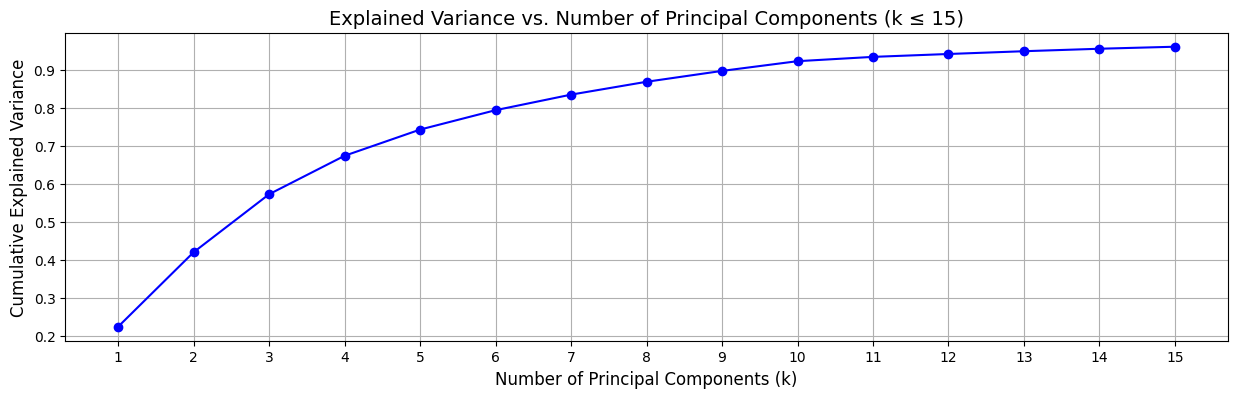

The k value is: 10


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Collect 'final_features' into a NumPy array for PCA computation
features = np.array(df.rdd.map(lambda row: row["final_features"].toArray()).collect())

# Step 2: Normalize the data (zero mean for each feature)
mean = np.mean(features, axis=0)
normalized_features = features - mean

# Step 3: Compute the covariance matrix
covariance_matrix = np.cov(normalized_features, rowvar=False)

# Step 4: Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Step 5: Sort eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]

# Step 6: Compute explained variance ratio for each k
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Step 7: Limit k to 15 for plotting
max_k = 15
actual_k = min(max_k, len(cumulative_variance_ratio))
limited_cumulative_variance_ratio = cumulative_variance_ratio[:actual_k]

# Plot cumulative variance explained for available k values
plt.figure(figsize=(15, 4))
plt.plot(range(1, actual_k + 1), limited_cumulative_variance_ratio, marker='o', color='b')
plt.title('Explained Variance vs. Number of Principal Components (k ≤ 15)', fontsize=14)
plt.xlabel('Number of Principal Components (k)', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.xticks(range(1, actual_k + 1))
plt.grid()
plt.show()

k = np.argmax(limited_cumulative_variance_ratio >= 0.9) + 1 # +1 because of zero-indexing
print(f"The k value is: {k}")


## Clustering

### Applying TSNE 

**Purpose:**
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique specifically designed for visualizing high-dimensional data in a low-dimensional space (usually 2D or 3D).

**Details of t-SNE Algorithm**
- t-SNE minimizes the divergence between two probability distributions:
    1. $ P_{ij} $: Represents the pairwise similarities of points $i$ and $j$ in the high-dimensional space:
    $$
    P_{ij} = \frac{\exp\left(-\frac{\lVert x_i - x_j \rVert^2}{2\sigma_i^2}\right)}{\sum_{k \neq l} \exp\left(-\frac{\lVert x_k - x_l \rVert^2}{2\sigma_k^2}\right)}
    $$
    where $\sigma_i$ controls the variance of the Gaussian distribution centered at $x_i$.

    2. $ Q_{ij} $: Represents the pairwise similarities in the low-dimensional space:
    $$
    Q_{ij} = \frac{\left(1 + \lVert y_i - y_j \rVert^2 \right)^{-1}}{\sum_{k \neq l} \left(1 + \lVert y_k - y_l \rVert^2 \right)^{-1}}
    $$

- The algorithm minimizes the **Kullback-Leibler divergence** between $P_{ij}$ and $Q_{ij}$:
    $$
    KL(P \parallel Q) = \sum_{i \neq j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}
    $$

**Reason for Application:**
- The dataset may contain nonlinear patterns that cannot be effectively captured by linear dimensionality reduction techniques like PCA.
- t-SNE is particularly useful for clustering applications as it preserves local structure, meaning similar points in high-dimensional space are mapped closer together in the reduced space.
- In this case, applying t-SNE allows us to reduce the dimensionality of the dataset to 2D while retaining meaningful clusters for further analysis.

**Advantages:**
- Preserves neighborhood relationships between data points.
- Facilitates visualization of intrinsic clusters in high-dimensional data.


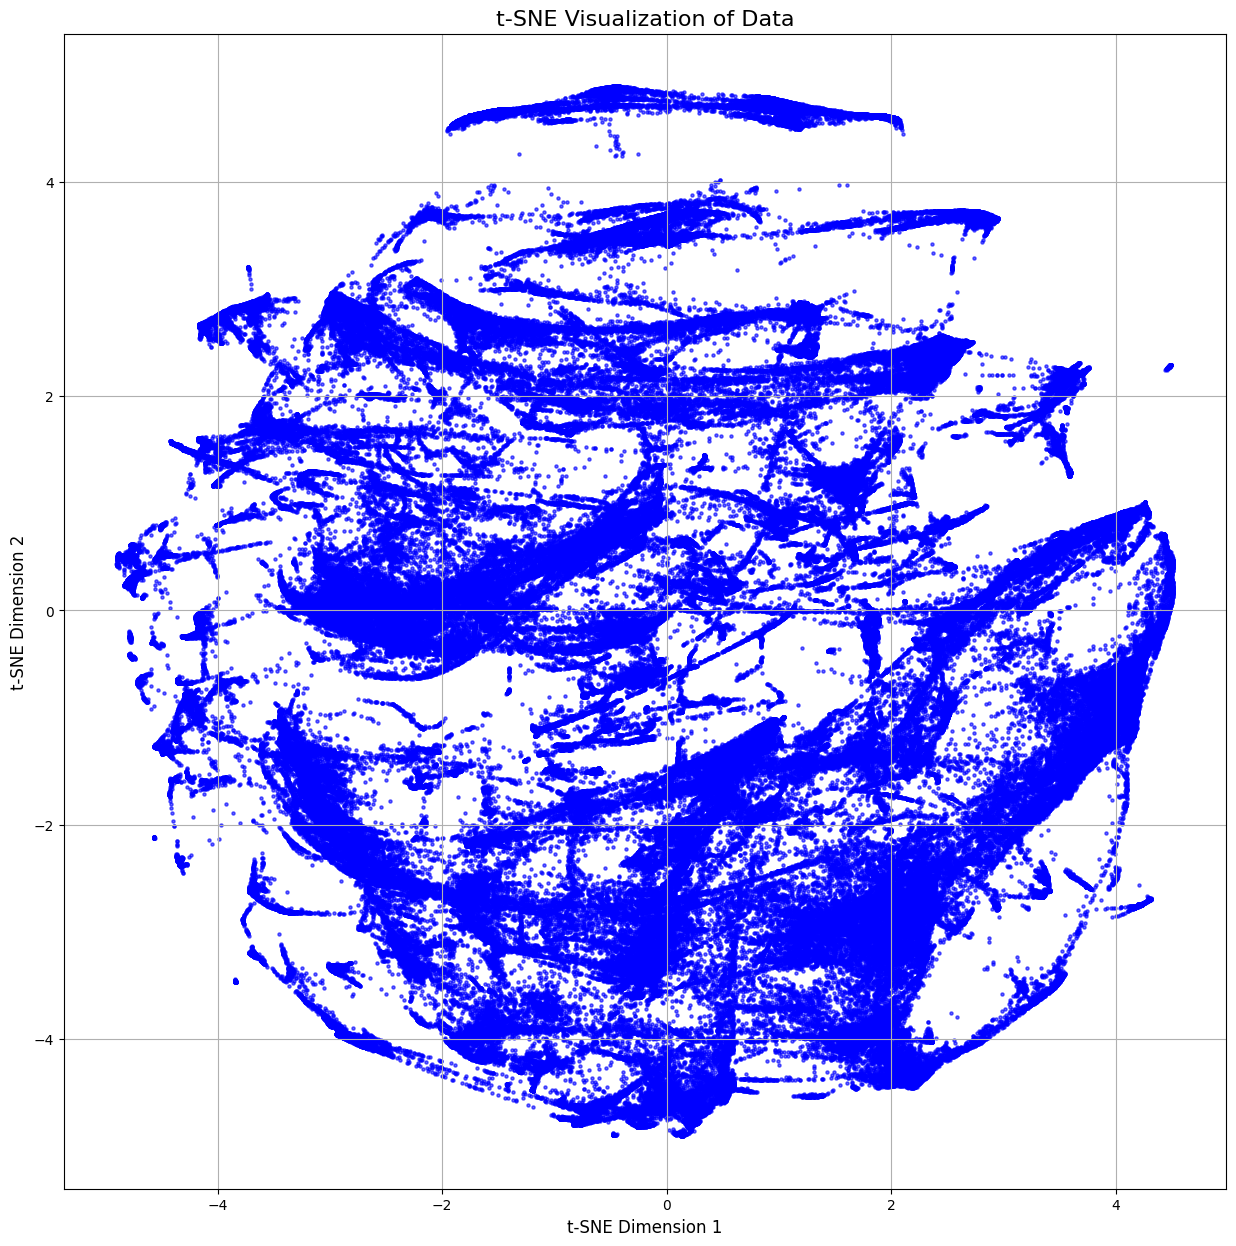

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Extract 'final_features' into a NumPy array
# features = np.array(df.rdd.map(lambda row: row["final_features"].toArray()).collect()) #already collected in previous part

# Step 2: Normalize the features
mean = np.mean(features, axis=0)
normalized_features = features - mean

# Step 3: Apply t-SNE
# Set parameters for t-SNE
tsne = TSNE(n_components=2,metric='cosine', perplexity=30, learning_rate=200, n_iter=250, random_state=42)
tsne_results = tsne.fit_transform(normalized_features)

# Step 4: Plot the 2D t-SNE result
plt.figure(figsize=(15, 15))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5, alpha=0.6, c='blue')
plt.title("t-SNE Visualization of Data", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.grid(True)
plt.show()

### Finding first 2 PCs 

- **Purpose:**
    PCA (Principal Component Analysis) is a linear dimensionality reduction method that identifies the directions (principal components) of maximum variance in the data.

- **Reason for Application:**
    - After applying t-SNE, the output is already in 2D space. However, t-SNE does not guarantee orthogonal axes or maximize variance.
    - Performing PCA on the t-SNE results ensures the principal components are uncorrelated (orthogonal) and represent maximum variability in the data.
    - The first two principal components derived from the t-SNE results provide meaningful directions for analyzing variance and clustering.

- **Advantages:**
    - Simplifies the data while retaining significant variance.
    - Creates orthogonal axes for easier interpretation.


In [2]:
from sklearn.decomposition import PCA

# Apply PCA to t-SNE results
pca = PCA(n_components=2)
pca_results = pca.fit_transform(tsne_results)

# Print explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio of PCs: {explained_variance_ratio}")


Explained Variance Ratio of PCs: [0.5616108 0.4383892]


### Clustering

**Purpose:**
    The BFR (Bradley-Fayyad-Reina) algorithm is designed for efficient clustering of large datasets. It processes data in chunks and maintains summaries for clusters rather than storing all data points.

**Details of BFR Algorithm**
- **Initialization**
  - Initialize $k=7$ cluster centers using a method like k-means++.

- **Chunk Processing**
    1. Divide the dataset into chunks.
    2. For each chunk, assign points to the nearest cluster based on **Euclidean distance**.

- **Cluster Summaries**
    - Maintain summaries for each cluster:
      - $N$: Number of points in the cluster.
      - $\text{SUM}$: Sum of all points in the cluster.
      - $\text{SUMSQ}$: Sum of squares of all points in the cluster.
    - Compute cluster means ($\mu$) and variances ($\sigma^2$):
      $$
      \mu = \frac{\text{SUM}}{N}, \quad \sigma^2 = \frac{\text{SUMSQ}}{N} - \mu^2
      $$

- **Outlier Handling**
  - Points with distances exceeding $3\sigma$ from any cluster are treated as outliers.

- **Merge Step**
  - Merge similar clusters by comparing distances and variances.

**Advantages:**
    - Scalable and efficient for large datasets.
    - Minimizes memory usage by summarizing clusters rather than storing individual data points.
    - Handles outliers effectively.


C:\Users\HAMAHANG\AppData\Local\Temp\ipykernel_22460\2173088822.py:82: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



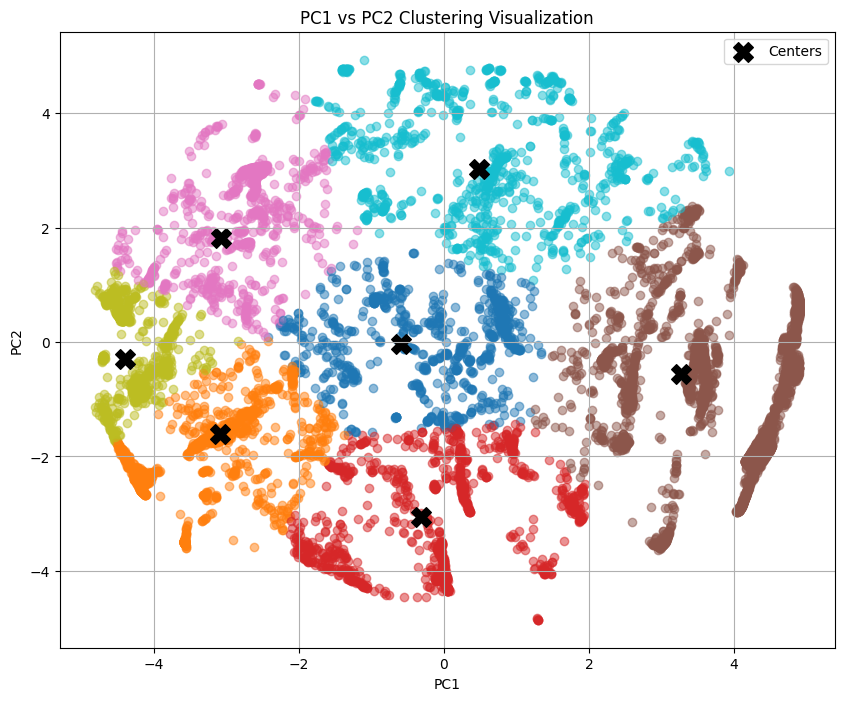

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Data: PCA results
data = np.array(pca_results)  # PCA results from previous steps
num_clusters = 7
chunk_size = len(data) // 3
chunks = [data[:chunk_size], data[chunk_size:2*chunk_size], data[2*chunk_size:]]

# Initialize clusters using k-means++ (manual implementation)
def initialize_clusters(data, k):
    centers = [data[random.randint(0, len(data) - 1)]]
    for _ in range(k - 1):
        distances = np.min([np.linalg.norm(data - c, axis=1) for c in centers], axis=0)
        probabilities = distances / np.sum(distances)
        next_center = data[np.random.choice(range(len(data)), p=probabilities)]
        centers.append(next_center)
    return np.array(centers)

# Initialize cluster summaries
def initialize_summaries(centers):
    summaries = {}
    for i, center in enumerate(centers):
        summaries[i] = {
            "N": 0,
            "SUM": np.zeros_like(center),
            "SUMSQ": np.zeros_like(center),
        }
    return summaries

# Update summaries with a new point
def update_summaries(summaries, cluster_id, point):
    summaries[cluster_id]["N"] += 1
    summaries[cluster_id]["SUM"] += point
    summaries[cluster_id]["SUMSQ"] += point**2

# Compute cluster distance
def compute_distance(point, center):
    return np.linalg.norm(point - center)

# Perform BFR clustering
def bfr_clustering(chunks, k):
    centers = initialize_clusters(chunks[0], k)
    summaries = initialize_summaries(centers)

    for chunk in chunks:
        for point in chunk:
            distances = [compute_distance(point, center) for center in centers]
            cluster_id = np.argmin(distances)

            # Threshold to determine outliers
            threshold = 3 * np.sqrt(np.var([center for center in centers]))
            if distances[cluster_id] > threshold:
                # Treat as outlier
                continue

            # Update cluster summaries
            update_summaries(summaries, cluster_id, point)

        # Recompute centers after processing a chunk
        for cluster_id, summary in summaries.items():
            if summary["N"] > 0:
                centers[cluster_id] = summary["SUM"] / summary["N"]

    return summaries, centers

# Perform clustering
summaries, centers = bfr_clustering(chunks, num_clusters)

# Extract cluster assignments
cluster_assignments = []
for point in data:
    distances = [compute_distance(point, center) for center in centers]
    cluster_assignments.append(np.argmin(distances))

# Visualize the clusters
def plot_clusters(data, cluster_assignments, centers):
    plt.figure(figsize=(10, 8))
    
    # Define a color map
    colors = plt.cm.get_cmap('tab10', len(np.unique(cluster_assignments)))
    
    # Plot each point with its cluster color
    for i in range(len(data)):
        plt.scatter(data[i, 0], data[i, 1], color=colors(cluster_assignments[i]), alpha=0.5)

    # Plot the centers
    plt.scatter(centers[:, 0], centers[:, 1], color='black', marker='X', s=200, label='Centers')
    
    # Add labels and title
    plt.title('PC1 vs PC2 Clustering Visualization')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot
plot_clusters(data[:10000], cluster_assignments, centers)


In [17]:
import pickle
# Save the ndarray to a .npy file
np.save('centers.npy', centers)

# Save the list using pickle
with open('cluster_assignments.pkl', 'wb') as f:
    pickle.dump(cluster_assignments, f)

np.save('data.npy', data)


## Evaluation metrics

### Silhouette Score

- **What It Evaluates**
    The **Silhouette Score** measures how similar data points are to their assigned cluster compared to other clusters. It considers:
    - **Cohesion**: How close a point is to other points in the same cluster.
    - **Separation**: How far the point is from points in other clusters.

- **Range**
    $$
    \text{Silhouette Score} \in [-1, 1]
    $$
    - $1$: Perfect clustering (points are well-matched to their own cluster and far from others).
    - $0$: Overlapping clusters (indistinct boundaries between clusters).
    - $-1$: Misclassified points (closer to another cluster than their own).

- **Strengths in Our Case**
    - Works well with **dimensionality-reduced data** (e.g., t-SNE, PCA).
    - Highlights poorly separated clusters when t-SNE preserves local relationships.
    - Easy to interpret: Higher scores indicate better-defined clusters.


In [1]:
import pickle
import numpy as np
with open('cluster_assignments.pkl', 'rb') as file:
    cluster_assignments = pickle.load(file)
tsne_results=np.load('tsne_results.npy')
data=np.load('data.npy')
centers=np.load('centers.npy')

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

# Data: tsne_results and cluster assignments
# tsne_results: Numpy array of shape (n_samples, 2)
# cluster_labels: List or array of cluster labels

def silhouette_score(tsne_results, cluster_labels):
    unique_clusters = np.unique(cluster_labels)
    n_samples = tsne_results.shape[0]
    
    silhouette_values = np.zeros(n_samples)
    
    for i in range(n_samples):
        # Get distances to all other points
        distances = np.linalg.norm(tsne_results - tsne_results[i], axis=1)
        
        # Identify the cluster of the current point
        current_cluster = cluster_labels[i]
        
        # Cohesion: Average distance to points in the same cluster
        same_cluster_mask = cluster_labels == current_cluster
        a_i = np.mean(distances[same_cluster_mask]) if np.sum(same_cluster_mask) > 1 else 0
        
        # Separation: Average distance to the nearest other cluster
        b_i = np.inf
        for cluster in unique_clusters:
            if cluster != current_cluster:
                other_cluster_mask = cluster_labels == cluster
                b_i = min(b_i, np.mean(distances[other_cluster_mask]))
        
        # Silhouette value for point i
        silhouette_values[i] = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0
    
    # Overall Silhouette Score
    return np.mean(silhouette_values)

sil_score = silhouette_score(tsne_results[:50000], cluster_assignments[:50000]) #if contain(all data)==>extensive run-time
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.42960626042271594


### Davies-Bouldin Index

The **Davies-Bouldin Index** evaluates:
  - **Compactness**: How close points within a cluster are to their centroid.
  - **Separation**: How far centroids of different clusters are from each other.

**Range**
$$
\text{Davies-Bouldin Index} \in [0, \infty)
$$
- **Lower values are better**: Smaller values indicate compact and well-separated clusters.

**Strengths in Our Case**
  - Suitable for **centroid-based clustering** like BFR.
  - Reflects issues such as overlapping clusters or large intra-cluster variability.
  - Can highlight how well BFR balances compactness and separation.


In [20]:
import numpy as np

# Sample cluster data
clusters = np.array(cluster_assignments)  # Cluster assignments for each point
data = tsne_results  # 2D data from t-SNE

# Step 1: Compute compactness (S_i) for each cluster
def compute_compactness(data, clusters, centroids):
    compactness = []
    for i in range(len(centroids)):
        cluster_points = data[clusters == i]
        centroid = centroids[i]
        S_i = np.mean(np.linalg.norm(cluster_points - centroid, axis=1))
        compactness.append(S_i)
    return compactness

compactness = compute_compactness(data, clusters, centers)

# Step 2: Compute separation (M_ij) between clusters
def compute_separation(centroids):
    n_clusters = len(centroids)
    separation = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            separation[i, j] = np.linalg.norm(centroids[i] - centroids[j])
            separation[j, i] = separation[i, j]
    return separation

separation = compute_separation(centers)

# Step 3: Compute R_ij and find the maximum R_ij for each cluster
def compute_dbi(compactness, separation):
    n_clusters = len(compactness)
    R = np.zeros((n_clusters, n_clusters))
    max_r = np.zeros(n_clusters)

    for i in range(n_clusters):
        for j in range(n_clusters):
            if i != j:
                R[i, j] = (compactness[i] + compactness[j]) / separation[i, j]
        max_r[i] = np.max(R[i])
    return np.mean(max_r)

dbi = compute_dbi(compactness, separation)

print(f"Davies-Bouldin Index: {dbi}")


Davies-Bouldin Index: 4.129832832292689


### Comparison

| **Aspect**              | **Silhouette Score**                     | **Davies-Bouldin Index**                 |
|-------------------------|------------------------------------------|------------------------------------------|
| **Evaluates**           | Point-level cohesion and separation      | Centroid-level compactness and separation|
| **Range**               | $[-1, 1]$, Higher is better            | $[0, \infty)$, Lower is better         |
| **Interpretability**    | Intuitive and bounded                    | Less intuitive due to unbounded range    |
| **Sensitivity to t-SNE**| Sensitive to local structure preservation| Captures overall cluster quality         |
| **Fit for BFR**         | May not emphasize centroids effectively  | Ideal for centroid-based clustering      |

---

**Our Case**

In our case:
1. **Silhouette Score(`0.429`)** is better at measuring **point-level compactness and separability**, aligning with the t-SNE step preserving local relationships.
2. **Davies-Bouldin Index(`4.129`)** is more suited for evaluating **overall cluster quality** in centroid-based approaches like BFR.

 - **Final Choice**  
        Since our final clustering step (BFR) is centroid-based, the **Davies-Bouldin Index** is more appropriate for evaluating how well centroids represent clusters and how distinct the clusters are. This ensures a meaningful evaluation.
        $$
        \textbf{Chosen Metric: Davies-Bouldin Index}
        $$

## Saving

**We save index of each cluster's points**

In [28]:
import pandas as pd

num_clusters=len(centers)
# Cluster assignment: map sampled indices to their cluster
cluster_indices = {i: [] for i in range(num_clusters)}

for idx, cluster_id in zip(sampled_indices, cluster_assignments):
    cluster_indices[cluster_id].append(idx)

# Load the existing Excel file
file_path = "Evaluate_P1.xlsx"
try:
    existing_data = pd.read_excel(file_path)
except FileNotFoundError:
    print(f"File {file_path} not found. Creating a new file.")
    existing_data = pd.DataFrame()

# Prepare cluster data
cluster_data = {
    f"C{i+1}": cluster_indices[i] if i in cluster_indices else []
    for i in range(num_clusters)
}

# Pad columns with NaN to ensure equal length
max_length = max(len(indices) for indices in cluster_data.values())
for key in cluster_data:
    cluster_data[key] += [None] * (max_length - len(cluster_data[key]))

# Convert to DataFrame
cluster_df = pd.DataFrame(cluster_data)

# Update the existing file's data with new cluster data
for col in cluster_df.columns:
    existing_data[col] = cluster_df[col]

# Save the updated file
existing_data.to_excel(file_path, index=False)
print(f"Updated cluster data saved to {file_path}")

Updated cluster data saved to Evaluate_P1.xlsx


# Recommender systems

## Implementing recommender system

### Description

**item-item collaborative filtering system**

- Baseline Estimate Calculation
    
    Each predicted rating $r_{xi}$ incorporates a baseline estimate $b_{xi}$ , accounting for overall trends:

    $$
    b_{xi} = \mu + b_x + b_i
    $$

    Where:
    - $ \mu $: Overall mean book rating.
    - $ b_x = \bar{r}_x - \mu $: User $x$'s rating deviation from $\mu$.
    - $ b_i = \bar{r}_i - \mu $: Book $i$'s rating deviation from $\mu$.

    > overall_mean = ratings_df.select(F.avg("Rating")).first()[0] <br>
    > user_avg = ratings_df.filter(F.col("User_Id") == user_id).select(F.avg("Rating")).first()[0] <br>
    > bx = user_avg - overall_mean if user_avg else 0 <br>
    > book_avg = ratings_df.filter(F.col("Book_Id") == book_id).select(F.avg("Rating")).first()[0] <br>
    > bi = book_avg - overall_mean if book_avg else 0 <br>
    > bxi = overall_mean + bx + bi <br>

- Similarity Calculation
  
    The similarity between two books $i$ and $j$, rated by common users, is computed using the **Pearson correlation coefficient**:

    $$
    s_{ij} = \frac{\sum_{u \in U_{ij}} (r_{ui} - \bar{r}_i)(r_{uj} - \bar{r}_j)}{\sqrt{\sum_{u \in U_{ij}} (r_{ui} - \bar{r}_i)^2} \sqrt{\sum_{u \in U_{ij}} (r_{uj} - \bar{r}_j)^2}}
    $$

  - Where:
      - $U_{ij}$: Set of users who rated both books $i$ and $j$.
      - $ \bar{r}_i $: Average rating for book $i$.
      - $ \bar{r}_j $: Average rating for book $j$.
    
    > common_ratings = ratings_i.join(ratings_j, "User_Id")<br>
    > mean_i = common_ratings.select(F.avg("i.Rating")).first()[0]<br>
    > mean_j = common_ratings.select(F.avg("j.Rating")).first()[0]<br>
    > numerator = common_ratings.withColumn("diff_i", F.col("i.Rating") - mean_i) \ <br>
    > $\quad$ .withColumn("diff_j", F.col("j.Rating") - mean_j) \ <br>
    > $\quad$ .withColumn("product", F.col("diff_i") * F.col("diff_j")) \ <br>
    > $\quad$ .select(F.sum("product")).first()[0]
    

- Top- $k$  Nearest Neighbors
    - From the set of books rated by the user, the top- $k$ most similar books to the target book $i$ are - selected based on $s_{ij}$.
    > similarities = sorted(similarities, key=lambda x: -x[1])[:k]

- Rating Prediction
  
    The predicted rating $r_{xi}$ is calculated as:

    $$
    r_{xi} = b_{xi} + \frac{\sum_{j \in N(i;x)} s_{ij} \cdot (r_{xj} - b_{xj})}{\sum_{j \in N(i;x)} |s_{ij}|}
    $$

    Where:
    - $ N(i;x) $: Set of top- $k$ similar books to $i$, rated by user $x$.
    - $ r_{xj} $: User $x$'s rating for book $j$.
    - $ b_{xj} $: Baseline estimate for book $j$.
    > numerator = sum(similarity * (rating_j - (overall_mean + bxj)) for _, similarity, rating_j in similarities)<br>
    > denominator = sum(abs(similarity) for _, similarity, _ in similarities)<br>
    > predicted_rating = bxi + (numerator / denominator if denominator != 0 else 0)<br>

- Edge Cases
  - **Existing Ratings**: If the user already rated the book, the actual rating is returned.
  > if existing_rating:<br>
  > $\quad$ return existing_rating["Rating"]
  - **No Neighbors**: If no similar books are found, the baseline estimate \( b_{xi} \) is returned.
  > if not similarities:<br>
  > $\quad$ return bxi


### Preprocessing

In [16]:
df = spark.read.csv("BookRates_DS.csv", header=False, inferSchema=True)

# # Calculate the number of rows
n = df.count()

# Get the first half of the DataFrame
df = df.limit(n//2)

# Rename columns
df = df.withColumnRenamed("_c0", "User_Id") \
       .withColumnRenamed("_c1", "Book_Id") \
       .withColumnRenamed("_c2", "Rating") \
       .withColumnRenamed("_c3", "Date") \
       
df.show(5, truncate = False)

+--------------+----------+------+----------+
|User_Id       |Book_Id   |Rating|Date      |
+--------------+----------+------+----------+
|AH2L9G3DQHHAJ |0000000116|4.0   |1019865600|
|A2IIIDRK3PRRZY|0000000116|1.0   |1395619200|
|A1TADCM7YWPQ8M|0000000868|4.0   |1031702400|
|AWGH7V0BDOJKB |0000013714|4.0   |1383177600|
|A3UTQPQPM4TQO0|0000013714|5.0   |1374883200|
+--------------+----------+------+----------+
only showing top 5 rows



### Predict

In [68]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from math import sqrt

def compute_similarity(item_i, item_j, ratings_df):
    """
    Compute the similarity (e.g., Pearson correlation coefficient) between two items.
    """
    # Filter ratings for both items i and j
    ratings_i = ratings_df.filter(F.col("Book_Id") == item_i).select("User_Id", "Rating").alias("i")
    ratings_j = ratings_df.filter(F.col("Book_Id") == item_j).select("User_Id", "Rating").alias("j")
    
    # Join on User_Id
    common_ratings = ratings_i.join(ratings_j, "User_Id")
    
    if common_ratings.count() == 0:
        return 0  # No common users; similarity is 0
    
    # Calculate mean ratings for i and j
    mean_i = common_ratings.select(F.avg("i.Rating")).first()[0]
    mean_j = common_ratings.select(F.avg("j.Rating")).first()[0]
    
    # Compute numerator and denominator for Pearson correlation
    common_ratings = common_ratings.withColumn("diff_i", F.col("i.Rating") - mean_i) \
                                   .withColumn("diff_j", F.col("j.Rating") - mean_j) \
                                   .withColumn("product", F.col("diff_i") * F.col("diff_j"))
    
    numerator = common_ratings.select(F.sum("product")).first()[0]
    denominator = sqrt(common_ratings.select(F.sum(F.col("diff_i") ** 2)).first()[0]) * \
                  sqrt(common_ratings.select(F.sum(F.col("diff_j") ** 2)).first()[0])
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    return numerator / denominator


def predict_rating(user_id, book_id, ratings_df, k=5):
    """
    Predict the rating for a given user and book using item-item collaborative filtering.
    """
    # Check if the book is already rated by the user
    existing_rating = ratings_df.filter((F.col("User_Id") == user_id) & (F.col("Book_Id") == book_id)).select("Rating").first()
    if existing_rating:
        return existing_rating["Rating"]  # Return actual rating if already exists
    
    # Overall mean rating
    overall_mean = ratings_df.select(F.avg("Rating")).first()[0]
    
    # User bias (bx)
    user_avg = ratings_df.filter(F.col("User_Id") == user_id).select(F.avg("Rating")).first()[0]
    bx = user_avg - overall_mean if user_avg else 0
    
    # Book bias (bi)
    book_avg = ratings_df.filter(F.col("Book_Id") == book_id).select(F.avg("Rating")).first()[0]
    bi = book_avg - overall_mean if book_avg else 0
    
    # Baseline estimate
    bxi = overall_mean + bx + bi
    
    # Find other books rated by the user
    user_books = ratings_df.filter(F.col("User_Id") == user_id).select("Book_Id", "Rating").collect()
    
    # Compute similarities with the target book
    similarities = []
    for row in user_books:
        book_j = row["Book_Id"]
        rating_j = row["Rating"]
        similarity = compute_similarity(book_id, book_j, ratings_df)
        if similarity > 0:  # Only consider positive similarities
            similarities.append((book_j, similarity, rating_j))
    
    # Select top-k similar books
    similarities = sorted(similarities, key=lambda x: -x[1])[:k]
    
    if not similarities:
        return bxi  # Return baseline estimate if no neighbors are found
    
    # Compute weighted average
    numerator = sum(similarity * (rating_j - (overall_mean + (rating_j - overall_mean))) for _, similarity, rating_j in similarities)
    denominator = sum(abs(similarity) for _, similarity, _ in similarities)
    
    return bxi + (numerator / denominator if denominator != 0 else 0)


# Find a random user
random_user = df.select("User_Id").distinct().orderBy(F.rand()).first()[0]

# Find a book that the user has not rated
rated_books = df.filter(F.col("User_Id") == random_user).select("Book_Id").distinct()
all_books = df.select("Book_Id").distinct()
not_rated_books = all_books.subtract(rated_books)

if not_rated_books.count() > 0:
    random_book = not_rated_books.orderBy(F.rand()).first()[0]
    
    # Predict the rating for the not-rated book
    predicted_rating = predict_rating(random_user, random_book, df)
    print(f"Predicted rating for User {random_user} on Book {random_book}: {predicted_rating}")
else:
    print(f"No books available that User {random_user} has not rated.")


Predicted rating for User AQIY318OX7XYW on Book 0001468685: 1.8137943293929428


## Evaluation 

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window
import random
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import math

# 1. Select 25% of books randomly
books = df.select("Book_Id").distinct().collect()
sampled_books = random.sample([row["Book_Id"] for row in books], int(0.25 * len(books)))

# 2. Mask 25% of ratings for the sampled books
masked_df = df.filter(F.col("Book_Id").isin(sampled_books))
unmasked_df = df.subtract(masked_df)

# Randomly sample 25% of ratings for the selected books
mask_window = Window.partitionBy("Book_Id")
masked_df = masked_df.withColumn("rand", F.rand()) \
    .withColumn("mask_flag", F.when(F.col("rand") <= 0.25, 1).otherwise(0)) \
    .filter(F.col("mask_flag") == 1) \
    .drop("rand", "mask_flag")

# Remaining ratings after masking
available_df = df.subtract(masked_df)

# Ground truth for masked ratings
ground_truth_df = masked_df.select("User_Id", "Book_Id", "Rating")

# Collect item-user ratings into a Python dictionary
ratings_data = df.groupBy("Book_Id").agg(F.collect_list(F.struct("User_Id", "Rating")).alias("ratings")).collect()

# Create a dictionary mapping Book_Id to its ratings
item_ratings_dict = {row["Book_Id"]: [(x["User_Id"], x["Rating"]) for x in row["ratings"]] for row in ratings_data}

# Broadcast the dictionary
item_ratings_broadcast = spark.sparkContext.broadcast(item_ratings_dict)

def predict_rating_v01(user_id, book_id, item_ratings):
    """
    Predict the rating for a given user and book using broadcasted data.
    """
    # Baseline predictions (mean ratings)
    overall_mean = sum([r for ratings in item_ratings.values() for _, r in ratings]) / sum([len(ratings) for ratings in item_ratings.values()])
    user_ratings = [(bid, rating) for bid, ratings in item_ratings.items() for uid, rating in ratings if uid == user_id]

    if not user_ratings:
        return overall_mean  # Return overall mean if the user has no ratings

    # Compute similarity-weighted average
    similarities = []
    for book_j, rating_j in user_ratings:
        ratings_i = item_ratings.get(book_id, [])
        ratings_j = item_ratings.get(book_j, [])

        # Compute similarity
        common_users = set(uid for uid, _ in ratings_i) & set(uid for uid, _ in ratings_j)
        if not common_users:
            continue

        mean_i = sum(r for uid, r in ratings_i if uid in common_users) / len(common_users)
        mean_j = sum(r for uid, r in ratings_j if uid in common_users) / len(common_users)

        numerator = sum(
            (r_i - mean_i) * (r_j - mean_j)
            for (uid, r_i) in ratings_i
            for (uid_j, r_j) in ratings_j
            if uid == uid_j
        )
        denominator = sqrt(
            sum((r_i - mean_i) ** 2 for uid, r_i in ratings_i if uid in common_users) *
            sum((r_j - mean_j) ** 2 for uid, r_j in ratings_j if uid in common_users)
        )

        similarity = numerator / denominator if denominator != 0 else 0
        similarities.append((similarity, rating_j))

    # Aggregate weighted ratings
    numerator = sum(sim * rating for sim, rating in similarities)
    denominator = sum(abs(sim) for sim, _ in similarities)

    return overall_mean + (numerator / denominator if denominator != 0 else 0)

@udf(DoubleType())
def predict_rating_udf(user_id, book_id):
    return predict_rating_v01(user_id, book_id, item_ratings_broadcast.value)

# Generate predictions
predictions_df = ground_truth_df.withColumn(
    "Predicted_Rating",
    predict_rating_udf(F.col("User_Id"), F.col("Book_Id"))
)

# Compute RMSE
rmse = predictions_df.withColumn(
    "squared_error", F.pow(F.col("Rating") - F.col("Predicted_Rating"), 2)
).select(F.avg("squared_error").alias("mse")).withColumn(
    "rmse", F.sqrt(F.col("mse"))
).select("rmse").first()["rmse"]

print(f"RMSE: {rmse}")



RMSE: 4.0301960237651135


## Saving

In [75]:
import pandas as pd
from pyspark.sql.functions import when, col

# Load the input data
df_eval = spark.read.csv("Evaluate_P2.csv", header=False, inferSchema=True)

# Rename columns
df_eval = df_eval.withColumnRenamed("_c0", "User_Id") \
                 .withColumnRenamed("_c1", "Book_Id") \
                 .withColumnRenamed("_c2", "Rating")

# Apply the UDF to estimate ratings for rows with question marks
df_with_estimated_ratings = df_eval.withColumn(
    "Rating",
    when(
        col("Rating") == "?", 
        predict_rating(col("User_Id"), col("Book_Id"), df)  
    ).otherwise(col("Rating"))  
)
data = df_with_estimated_ratings.select("User_Id", "Book_Id", "Rating").collect()

columns = ["User_Id", "Book_Id", "Rating"]

# Create the DataFrame
Data_df = pd.DataFrame(data, columns=columns)
# Step 4: Save the DataFrame as a CSV file
Data_df.to_csv("Evaluate_P2.csv", index=False, header=False)